<a href="https://colab.research.google.com/github/hakmin1015/ArtificialIntelligence/blob/main/lab5/Homework_4_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 3. Hyper-parameter set Optimization
- find happy case of epoch and batch size
- coarse to fine cross-validation in stages : learning rate

### 준비 작업

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/MyDrive/AI/lab5/

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/MyDrive/AI/lab5


In [ ]:
import numpy as np
from numpy.random import randn

def unpickle(file):
  import pickle
  with open(file, 'rb') as fo:
    dict = pickle.load(fo, encoding='bytes')
  return dict

bat1 = unpickle('data_batch_1')
bat2 = unpickle('data_batch_2')
bat3 = unpickle('data_batch_3')
bat4 = unpickle('data_batch_4')
bat5 = unpickle('data_batch_5')
bat_test = unpickle('test_batch')

data = np.concatenate([bat1[b'data'], bat2[b'data'],
bat3[b'data'],bat4[b'data'], bat5[b'data']])
labels = np.concatenate([bat1[b'labels'],
bat2[b'labels'], bat3[b'labels'],bat4[b'labels'],
bat5[b'labels']])

t_data = bat1[b'data'].astype("float")
labels = bat1[b'labels']

N, D_in = np.shape(t_data)
H, D_out = 500, 10
t_label = np.zeros((N, D_out))

for i in range(N):
    t_label[i, labels[i]] = 1   # one hot vector

w1, w2 = randn(D_in, H) * 0.01, randn(H, D_out) * 0.01  # weight initialization

In [ ]:
def sigmoid(x: np.ndarray) -> np.ndarray:  # 안전한 version
    positives = x >= 0
    negatives = ~positives
    exp_x_neg = np.exp(x[negatives])
    y = x.copy()
    y[positives] = 1 / (1 + np.exp(-x[positives]))
    y[negatives] = exp_x_neg / (1 + exp_x_neg)
    return y

sigmoid_fn = lambda x: 1 / (1 + np.exp(-x))  # 일반 version
relu_fn = lambda x: x * (x > 0)

### learning rate optimization
- epoch과 batch size를 수동으로 조절하고 learning rate는 균등한 분포를 따르는 random 함수를 통해 10번의 테스트 동안 자동으로 바뀌게 설정함.

In [ ]:
t_data = bat1[b'data'].astype("float")

labels_1d = bat1[b'labels']
labels_arr = np.array(labels_1d)
labels = labels_arr.reshape(-1,1)

N, D_in = np.shape(t_data)
H, D_out = 500, 10

# epoch
epoch = 1

# mini batch
bat_size = 100

repeat = int(N/bat_size)

t_label = np.zeros((bat_size, D_out, repeat))

import random

used_indices = set()
rand_indices_list = []
mini_batch_data = np.zeros((bat_size,D_in,repeat))
mini_batch_label = np.zeros((bat_size,1,repeat))

for i in range(repeat):
    available_indices = [idx for idx in range(N) if idx not in used_indices]
    rand_idx = np.random.choice(available_indices, bat_size, replace=False)

    used_indices.update(rand_idx)
    #rand_indices_list.append(rand_idx)    # random index for mini batch
    mini_batch_data[:,:,i] = t_data[rand_idx]
    mini_batch_label[:,:,i] = labels[rand_idx]

    mini_batch_label = mini_batch_label.astype('int')

    for j in range(bat_size):
      t_label[j,mini_batch_label[j,0,i],i] = 1

1) epoch = 20, batch size = 100, lr = 10**uniform(-5, -6)일 때

In [ ]:
# Softmax loss

losses_Softmax = []
test_size = 10
results = []  # List to store results

for k in range(test_size):
    print('test_size ' + str(k))
    w1, w2 = randn(D_in, H)*0.01, randn(H, D_out)*0.01  # weight initialization
    lr = 10**uniform(-5, -6)

    losses_all_SoftMax = []  # 모든 loss를 전부 저장할 리스트
    losses_per_epoch_SoftMax = []  # 각 에폭의 loss 평균을 저장할 리스트

    for t in range(epoch):
        print('epoch ' + str(t))
        losses_temp = []  # 각 epoch 별 loss를 저장할 리스트

        for i in range(repeat):
            t_data = mini_batch_data[:, :, i]
            z = np.dot(t_data, w1)

            # Batch Normalization
            z_mean = np.mean(z, axis=0)
            z_std = np.std(z, axis=0)
            z = (z - z_mean) / z_std

            z -= np.max(z)
            h = sigmoid(z)
            y_pred = h.dot(w2)
            z = h.dot(w2)
            z_max = np.max(z, axis=1)
            z -= z_max[:, None]
            exp_s = np.exp(z)
            exp_y_s = exp_s[range(len(t_label[:, :, i])), t_label[:, 1, i].astype('int')]
            ti = exp_s / np.sum(exp_s, axis=1)[:, None]
            loss_i = -np.log(exp_y_s / np.sum(exp_s, axis=1))
            loss = np.sum(loss_i)
            losses_temp.append(loss)
            losses_all_SoftMax.append(loss)
            # print(i, loss)

            grad_s = ti - t_label[:, :, i]
            grad_w2 = h.T.dot(grad_s)
            grad_h = grad_s.dot(w2.T)
            grad_w1 = t_data.T.dot(grad_h * h * (1 - h))

            w1 -= lr * grad_w1
            w2 -= lr * grad_w2

        # 각 epoch 별 loss의 평균을 구하여 저장함
        loss_epoch_avg = np.mean(losses_temp)
        losses_per_epoch_SoftMax.append(loss_epoch_avg)

        # Test Set을 이용한 모델 정확도 측정
        test_data = bat_test[b'data']
        test_label = bat_test[b'labels']

        z = np.dot(test_data, w1)
        z -= np.max(z)
        h = sigmoid(z)
        ti = h.dot(w2)

        Y_predict = np.argmax(ti, axis=1)
        acc = np.mean(Y_predict == test_label) * 100

    results.append((acc, lr, k, test_size))

for acc, lr, k, test_size in results:
    print("accuracy: {:.6f}, lr: {:.6f}, ({:d} / {:d})".format(acc, lr, k, test_size))

test_size 0
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
test_size 1
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
test_size 2
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
test_size 3
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
test_size 4
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
test_size 5
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 

2) epoch = 1, batch size = 100, lr = 10**uniform(-3, -5)일 때

In [ ]:
import random
from random import uniform
import numpy as np
from numpy.random import randn

# Softmax loss
losses_Softmax = []
test_size = 10
results = []  # List to store results

for k in range(test_size):
    print('test_size ' + str(k))
    w1, w2 = randn(D_in, H)*0.01, randn(H, D_out)*0.01  # weight initialization
    lr = 10**uniform(-3, -5)

    losses_all_SoftMax = []  # 모든 loss를 전부 저장할 리스트
    losses_per_epoch_SoftMax = []  # 각 에폭의 loss 평균을 저장할 리스트

    for t in range(epoch):
        print('epoch ' + str(t))
        losses_temp = []  # 각 epoch 별 loss를 저장할 리스트

        for i in range(repeat):
            t_data = mini_batch_data[:, :, i]
            z = np.dot(t_data, w1)

            # Batch Normalization
            z_mean = np.mean(z, axis=0)
            z_std = np.std(z, axis=0)
            z = (z - z_mean) / z_std

            z -= np.max(z)
            h = sigmoid(z)
            y_pred = h.dot(w2)
            z = h.dot(w2)
            z_max = np.max(z, axis=1)
            z -= z_max[:, None]
            exp_s = np.exp(z)
            exp_y_s = exp_s[range(len(t_label[:, :, i])), t_label[:, 1, i].astype('int')]
            ti = exp_s / np.sum(exp_s, axis=1)[:, None]
            loss_i = -np.log(exp_y_s / np.sum(exp_s, axis=1))
            loss = np.sum(loss_i)
            losses_temp.append(loss)
            losses_all_SoftMax.append(loss)
            print(i, loss)

            grad_s = ti - t_label[:, :, i]
            grad_w2 = h.T.dot(grad_s)
            grad_h = grad_s.dot(w2.T)
            grad_w1 = t_data.T.dot(grad_h * h * (1 - h))

            w1 -= lr * grad_w1
            w2 -= lr * grad_w2

        # 각 epoch 별 loss의 평균을 구하여 저장함
        loss_epoch_avg = np.mean(losses_temp)
        losses_per_epoch_SoftMax.append(loss_epoch_avg)

        # Test Set을 이용한 모델 정확도 측정
        test_data = bat_test[b'data']
        test_label = bat_test[b'labels']

        z = np.dot(test_data, w1)
        z -= np.max(z)
        h = sigmoid(z)
        ti = h.dot(w2)

        Y_predict = np.argmax(ti, axis=1)
        acc = np.mean(Y_predict == test_label) * 100

    results.append((acc, lr, k, test_size))

for acc, lr, k, test_size in results:
    print("accuracy: {:.6f}, lr: {:.6f}, ({:d} / {:d})".format(acc, lr, k, test_size))

test_size 0
epoch 0
0 230.1585601498791
1 230.23672862324307
2 230.23320190038922
3 230.17663630872667
4 230.2676467898761
5 230.19443365673516
6 230.25051516014227
7 230.12793637916064
8 230.1651140392959
9 230.13180924062723
10 230.19518549017906
11 230.28956172662114
12 230.19353489777987
13 230.1642376934603
14 230.13252957938417
15 230.2506218695749
16 230.24507675227588
17 230.09658856898736
18 230.20550117076047
19 230.22506061608198
20 230.15638826952488
21 230.046300127545
22 230.2468540211099
23 230.24686271150298
24 230.239306177817
25 230.16851734479783
26 230.14300108531745
27 230.20259100587
28 230.15601242427115
29 230.16805231284724
30 230.15935550081605
31 230.17257655806995
32 230.08757394048288
33 230.15658089974335
34 230.10619154356206
35 230.24300208162754
36 230.17181622359604
37 230.2138042464594
38 230.1949993576291
39 230.19307998498658
40 230.1605978985054
41 230.06226579732086
42 230.08067887686232
43 230.21860178548664
44 230.1798509147401
45 230.1763110951

epoch을 작은 수(1)로 줄였을 때 accuracy가 10.77까지 상승하는 것을 확인하였다. learning rate의 범위를 좁혀 같은 조건에서 다시 테스트하면 다음과 같다. <br/>
3) epoch = 1, batch size = 100, lr = 10**uniform(-4.5, -5.5)일 때

In [ ]:
import random
from random import uniform
import numpy as np
from numpy.random import randn

# Softmax loss
losses_Softmax = []
test_size = 10
results = []  # List to store results

for k in range(test_size):
    print('test_size ' + str(k))
    w1, w2 = randn(D_in, H)*0.01, randn(H, D_out)*0.01  # weight initialization
    lr = 10**uniform(-4.5, -5.5)

    losses_all_SoftMax = []  # 모든 loss를 전부 저장할 리스트
    losses_per_epoch_SoftMax = []  # 각 에폭의 loss 평균을 저장할 리스트

    for t in range(epoch):
        print('epoch ' + str(t))
        losses_temp = []  # 각 epoch 별 loss를 저장할 리스트

        for i in range(repeat):
            t_data = mini_batch_data[:, :, i]
            z = np.dot(t_data, w1)

            # Batch Normalization
            z_mean = np.mean(z, axis=0)
            z_std = np.std(z, axis=0)
            z = (z - z_mean) / z_std

            z -= np.max(z)
            h = sigmoid(z)
            y_pred = h.dot(w2)
            z = h.dot(w2)
            z_max = np.max(z, axis=1)
            z -= z_max[:, None]
            exp_s = np.exp(z)
            exp_y_s = exp_s[range(len(t_label[:, :, i])), t_label[:, 1, i].astype('int')]
            ti = exp_s / np.sum(exp_s, axis=1)[:, None]
            loss_i = -np.log(exp_y_s / np.sum(exp_s, axis=1))
            loss = np.sum(loss_i)
            losses_temp.append(loss)
            losses_all_SoftMax.append(loss)
            # print(i, loss)

            grad_s = ti - t_label[:, :, i]
            grad_w2 = h.T.dot(grad_s)
            grad_h = grad_s.dot(w2.T)
            grad_w1 = t_data.T.dot(grad_h * h * (1 - h))

            w1 -= lr * grad_w1
            w2 -= lr * grad_w2

        # 각 epoch 별 loss의 평균을 구하여 저장함
        loss_epoch_avg = np.mean(losses_temp)
        losses_per_epoch_SoftMax.append(loss_epoch_avg)

        # Test Set을 이용한 모델 정확도 측정
        test_data = bat_test[b'data']
        test_label = bat_test[b'labels']

        z = np.dot(test_data, w1)
        z -= np.max(z)
        h = sigmoid(z)
        ti = h.dot(w2)

        Y_predict = np.argmax(ti, axis=1)
        acc = np.mean(Y_predict == test_label) * 100

    results.append((acc, lr, k, test_size))

for acc, lr, k, test_size in results:
    print("accuracy: {:.6f}, lr: {:.6f}, ({:d} / {:d})".format(acc, lr, k, test_size))

test_size 0
epoch 0
test_size 1
epoch 0
test_size 2
epoch 0
test_size 3
epoch 0
test_size 4
epoch 0
test_size 5
epoch 0
test_size 6
epoch 0
test_size 7
epoch 0
test_size 8
epoch 0
test_size 9
epoch 0
accuracy: 11.320000, lr: 0.000005, (0 / 10)
accuracy: 10.000000, lr: 0.000019, (1 / 10)
accuracy: 10.220000, lr: 0.000010, (2 / 10)
accuracy: 10.530000, lr: 0.000010, (3 / 10)
accuracy: 10.000000, lr: 0.000022, (4 / 10)
accuracy: 6.860000, lr: 0.000020, (5 / 10)
accuracy: 11.790000, lr: 0.000004, (6 / 10)
accuracy: 10.250000, lr: 0.000015, (7 / 10)
accuracy: 9.650000, lr: 0.000017, (8 / 10)
accuracy: 10.000000, lr: 0.000030, (9 / 10)


4) epoch = 1, batch size = 100, lr = 4*10 * *uniform(-6, -7)일 때

In [ ]:
import random
from random import uniform
import numpy as np
from numpy.random import randn

# Softmax loss
losses_Softmax = []
test_size = 10
results = []  # List to store results

for k in range(test_size):
    print('test_size ' + str(k))
    w1, w2 = randn(D_in, H)*0.01, randn(H, D_out)*0.01  # weight initialization
    lr = 4*10**uniform(-6, -7)

    losses_all_SoftMax = []  # 모든 loss를 전부 저장할 리스트
    losses_per_epoch_SoftMax = []  # 각 에폭의 loss 평균을 저장할 리스트

    for t in range(epoch):
        print('epoch ' + str(t))
        losses_temp = []  # 각 epoch 별 loss를 저장할 리스트

        for i in range(repeat):
            t_data = mini_batch_data[:, :, i]
            z = np.dot(t_data, w1)

            # Batch Normalization
            z_mean = np.mean(z, axis=0)
            z_std = np.std(z, axis=0)
            z = (z - z_mean) / z_std

            z -= np.max(z)
            h = sigmoid(z)
            y_pred = h.dot(w2)
            z = h.dot(w2)
            z_max = np.max(z, axis=1)
            z -= z_max[:, None]
            exp_s = np.exp(z)
            exp_y_s = exp_s[range(len(t_label[:, :, i])), t_label[:, 1, i].astype('int')]
            ti = exp_s / np.sum(exp_s, axis=1)[:, None]
            loss_i = -np.log(exp_y_s / np.sum(exp_s, axis=1))
            loss = np.sum(loss_i)
            losses_temp.append(loss)
            losses_all_SoftMax.append(loss)
            # print(i, loss)

            grad_s = ti - t_label[:, :, i]
            grad_w2 = h.T.dot(grad_s)
            grad_h = grad_s.dot(w2.T)
            grad_w1 = t_data.T.dot(grad_h * h * (1 - h))

            w1 -= lr * grad_w1
            w2 -= lr * grad_w2

        # 각 epoch 별 loss의 평균을 구하여 저장함
        loss_epoch_avg = np.mean(losses_temp)
        losses_per_epoch_SoftMax.append(loss_epoch_avg)

        # Test Set을 이용한 모델 정확도 측정
        test_data = bat_test[b'data']
        test_label = bat_test[b'labels']

        z = np.dot(test_data, w1)
        z -= np.max(z)
        h = sigmoid(z)
        ti = h.dot(w2)

        Y_predict = np.argmax(ti, axis=1)
        acc = np.mean(Y_predict == test_label) * 100

    results.append((acc, lr, k, test_size))

for acc, lr, k, test_size in results:
    print("accuracy: {:.6f}, lr: {:.6f}, ({:d} / {:d})".format(acc, lr, k, test_size))

test_size 0
epoch 0
test_size 1
epoch 0
test_size 2
epoch 0
test_size 3
epoch 0
test_size 4
epoch 0
test_size 5
epoch 0
test_size 6
epoch 0
test_size 7
epoch 0
test_size 8
epoch 0
test_size 9
epoch 0
accuracy: 9.600000, lr: 0.000001, (0 / 10)
accuracy: 11.270000, lr: 0.000001, (1 / 10)
accuracy: 11.430000, lr: 0.000001, (2 / 10)
accuracy: 10.140000, lr: 0.000000, (3 / 10)
accuracy: 10.100000, lr: 0.000002, (4 / 10)
accuracy: 9.670000, lr: 0.000001, (5 / 10)
accuracy: 10.500000, lr: 0.000002, (6 / 10)
accuracy: 11.820000, lr: 0.000003, (7 / 10)
accuracy: 12.150000, lr: 0.000003, (8 / 10)
accuracy: 9.740000, lr: 0.000001, (9 / 10)


5) epoch = 1, batch size = 100, lr = 3* 10 **uniform(-6,-7)일 때

In [ ]:
import random
from random import uniform
import numpy as np
from numpy.random import randn

# Softmax loss
losses_Softmax = []
test_size = 10
results = []  # List to store results

for k in range(test_size):
    print('test_size ' + str(k))
    w1, w2 = randn(D_in, H)*0.01, randn(H, D_out)*0.01  # weight initialization
    lr = 3*10**uniform(-6,-7)

    losses_all_SoftMax = []  # 모든 loss를 전부 저장할 리스트
    losses_per_epoch_SoftMax = []  # 각 에폭의 loss 평균을 저장할 리스트

    for t in range(epoch):
        print('epoch ' + str(t))
        losses_temp = []  # 각 epoch 별 loss를 저장할 리스트

        for i in range(repeat):
            t_data = mini_batch_data[:, :, i]
            z = np.dot(t_data, w1)

            # Batch Normalization
            z_mean = np.mean(z, axis=0)
            z_std = np.std(z, axis=0)
            z = (z - z_mean) / z_std

            z -= np.max(z)
            h = sigmoid(z)
            y_pred = h.dot(w2)
            z = h.dot(w2)
            z_max = np.max(z, axis=1)
            z -= z_max[:, None]
            exp_s = np.exp(z)
            exp_y_s = exp_s[range(len(t_label[:, :, i])), t_label[:, 1, i].astype('int')]
            ti = exp_s / np.sum(exp_s, axis=1)[:, None]
            loss_i = -np.log(exp_y_s / np.sum(exp_s, axis=1))
            loss = np.sum(loss_i)
            losses_temp.append(loss)
            losses_all_SoftMax.append(loss)
            # print(i, loss)

            grad_s = ti - t_label[:, :, i]
            grad_w2 = h.T.dot(grad_s)
            grad_h = grad_s.dot(w2.T)
            grad_w1 = t_data.T.dot(grad_h * h * (1 - h))

            w1 -= lr * grad_w1
            w2 -= lr * grad_w2

        # 각 epoch 별 loss의 평균을 구하여 저장함
        loss_epoch_avg = np.mean(losses_temp)
        losses_per_epoch_SoftMax.append(loss_epoch_avg)

        # Test Set을 이용한 모델 정확도 측정
        test_data = bat_test[b'data']
        test_label = bat_test[b'labels']

        z = np.dot(test_data, w1)
        z -= np.max(z)
        h = sigmoid(z)
        ti = h.dot(w2)

        Y_predict = np.argmax(ti, axis=1)
        acc = np.mean(Y_predict == test_label) * 100

    results.append((acc, lr, k, test_size))

for acc, lr, k, test_size in results:
    print("accuracy: {:.6f}, lr: {:.6f}, ({:d} / {:d})".format(acc, lr, k, test_size))

test_size 0
epoch 0
test_size 1
epoch 0
test_size 2
epoch 0
test_size 3
epoch 0
test_size 4
epoch 0
test_size 5
epoch 0
test_size 6
epoch 0
test_size 7
epoch 0
test_size 8
epoch 0
test_size 9
epoch 0
accuracy: 9.750000, lr: 0.000002, (0 / 10)
accuracy: 11.670000, lr: 0.000002, (1 / 10)
accuracy: 10.680000, lr: 0.000002, (2 / 10)
accuracy: 9.930000, lr: 0.000000, (3 / 10)
accuracy: 9.750000, lr: 0.000001, (4 / 10)
accuracy: 11.020000, lr: 0.000000, (5 / 10)
accuracy: 11.570000, lr: 0.000003, (6 / 10)
accuracy: 11.590000, lr: 0.000001, (7 / 10)
accuracy: 8.530000, lr: 0.000001, (8 / 10)
accuracy: 10.270000, lr: 0.000001, (9 / 10)


여러 번의 테스트 결과, epoch의 크기가 커지면 accuracy의 최댓값은 10을 넘지 못하는 것으로 측정되었다. 이는 epoch이 커져 학습을 많이 하게 되어 과적합 현상이 발생한 것으로 추정된다. <br/>
따라서 여러 테스트 결과 중 epoch = 1, batch size = 100일 때 learning rate = 0.000003인 경우 test accuracy가 가장 높게 나온 것을 확인하였다. <br/>
따라서 최적의 Hyper-parameter set은 [epoch=1, batch_size=100, learning_rate=0.000003]으로 제시하며, 이 때 [test_accuracy=12.150000]이다.

### 4. Vanilla Code와의 비교

In [ ]:
import numpy as np
from numpy.random import randn

def unpickle(file):
  import pickle
  with open(file, 'rb') as fo:
    dict = pickle.load(fo, encoding='bytes')
  return dict

bat1 = unpickle('data_batch_1')
bat2 = unpickle('data_batch_2')
bat3 = unpickle('data_batch_3')
bat4 = unpickle('data_batch_4')
bat5 = unpickle('data_batch_5')
bat_test = unpickle('test_batch')

data = np.concatenate([bat1[b'data'], bat2[b'data'],
bat3[b'data'],bat4[b'data'], bat5[b'data']])
labels = np.concatenate([bat1[b'labels'],
bat2[b'labels'], bat3[b'labels'],bat4[b'labels'],
bat5[b'labels']])

t_data = bat1[b'data'].astype("float")
labels = bat1[b'labels']

N, D_in = np.shape(t_data)
H, D_out = 500, 10
t_label = np.zeros((N, D_out))

for i in range(N):
    t_label[i, labels[i]] = 1   # one hot vector

w1, w2 = randn(D_in, H) * 0.01, randn(H, D_out) * 0.01  # weight initialization

1) Vanilla Code

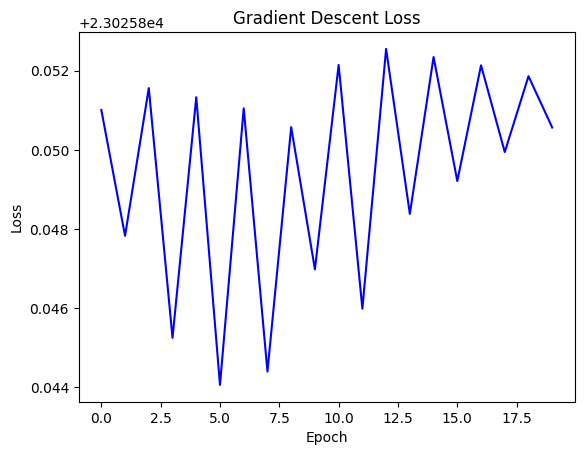

In [ ]:
import matplotlib.pyplot as plt

# Softmax loss

losses_GD = []  # List to store loss values

epoch = 20

for t in range(epoch):
    z = np.dot(t_data, w1)
    z -= np.max(z)
    # h = sigmoid_fn(z)     #일반 sigmoid 함수
    h = sigmoid(z)  # 안전한 sigmoid 함수
    z = h.dot(w2)
    z_max = np.max(z, axis=1)
    z -= z_max[:, None]

    exp_s = np.exp(z)
    exp_y_s = exp_s[range(len(labels)), labels]
    ti = exp_s / np.sum(exp_s, axis=1)[:, None]
    loss_i = -np.log(exp_y_s / np.sum(exp_s, axis=1))
    loss = np.sum(loss_i)
    losses_GD.append(loss)
    # print(t, loss)

    grad_s = ti - t_label
    grad_w2 = h.T.dot(grad_s)
    grad_h = grad_s.dot(w2.T)
    grad_w1 = t_data.T.dot(grad_h * h * (1 - h))

    lr = 1e-4
    w1 -= lr * grad_w1
    w2 -= lr * grad_w2

# 그래프로 손실 값 시각화
plt.plot(range(epoch), losses_GD, 'b-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Gradient Descent Loss')
plt.show()

2) Optimized Code

In [ ]:
t_data = bat1[b'data'].astype("float")

labels_1d = bat1[b'labels']
labels_arr = np.array(labels_1d)
labels = labels_arr.reshape(-1,1)

N, D_in = np.shape(t_data)
H, D_out = 500, 10

# Epoch
epoch = 1

# Code for mini batch
bat_size = 100

repeat = int(N/bat_size)

t_label = np.zeros((bat_size, D_out, repeat))

import random

used_indices = set()
rand_indices_list = []
mini_batch_data = np.zeros((bat_size,D_in,repeat))
mini_batch_label = np.zeros((bat_size,1,repeat))

for i in range(repeat):
    available_indices = [idx for idx in range(N) if idx not in used_indices]
    rand_idx = np.random.choice(available_indices, bat_size, replace=False)

    used_indices.update(rand_idx)
    #rand_indices_list.append(rand_idx)    # random index for mini batch
    mini_batch_data[:,:,i] = t_data[rand_idx]
    mini_batch_label[:,:,i] = labels[rand_idx]

    mini_batch_label = mini_batch_label.astype('int')

    for j in range(bat_size):
      t_label[j,mini_batch_label[j,0,i],i] = 1

In [ ]:
# Softmax loss

losses_Softmax = []

w1, w2 = randn(D_in, H)*0.01, randn(H, D_out)*0.01      # weight initialization

losses_all_SoftMax = []  # 모든 loss를 전부 저장할 리스트
losses_per_epoch_SoftMax = []  # 각 epoch의 loss 평균을 저장할 리스트

for t in range(epoch):
    print('epoch ' + str(t))
    losses_temp = []  # 각 epoch 별 loss를 저장할 리스트

    for i in range(repeat):
        t_data = mini_batch_data[:,:,i]
        z = np.dot(t_data, w1)

        # Batch Normalization
        z_mean = np.mean(z, axis=0)
        z_std = np.std(z, axis=0)
        z = (z - z_mean) / z_std

        z -= np.max(z)
        h = sigmoid(z)  # 안전한 sigmoid 함수
        y_pred = h.dot(w2)
        z = h.dot(w2)
        z_max = np.max(z, axis=1)
        z -= z_max[:,None]
        exp_s = np.exp(z)
        exp_y_s = exp_s[range(len(t_label[:,:,i])),t_label[:,1,i].astype('int')]
        ti = exp_s / np.sum(exp_s, axis = 1)[:,None]
        loss_i = -np.log(exp_y_s/np.sum(exp_s, axis = 1))
        loss = np.sum(loss_i)
        losses_temp.append(loss)
        losses_all_SoftMax.append(loss)
        print(i, loss)

        grad_s = ti - t_label[:,:,i]
        grad_w2 = h.T.dot(grad_s)
        grad_h = grad_s.dot(w2.T)
        grad_w1 = t_data.T.dot(grad_h * h * (1-h))

        lr = 0.000003
        w1 -= lr * grad_w1
        w2 -= lr * grad_w2

    # 각 epoch 별 loss의 평균을 구하여 저장함
    loss_epoch_avg = np.mean(losses_temp)
    losses_per_epoch_SoftMax.append(loss_epoch_avg)

epoch 0
0 230.07597410716178
1 230.05522380317694
2 230.1228444813389
3 230.11273220538453
4 230.19881967762015
5 230.04679181776777
6 230.13959863859768
7 230.11295998840092
8 230.15538746645058
9 230.15936557351023
10 230.15719932702564
11 230.19099320811097
12 230.1765998070551
13 230.1248259588414
14 230.1918443903396
15 230.1338225132392
16 230.0925997031725
17 230.1377612226114
18 230.07485997723253
19 230.0680101773665
20 230.1797473366711
21 230.15778329442185
22 230.1160103623001
23 230.1165872731511
24 230.06569529693883
25 230.04656832275228
26 230.06259485190506
27 230.04327159026738
28 230.17583531757867
29 230.20743306266925
30 230.12820467836485
31 230.09199489622037
32 230.12114004711935
33 230.12569324848542
34 230.04933351662459
35 230.0453278326314
36 230.0923806130739
37 230.19972300963988
38 230.12964632143417
39 230.1027182952033
40 230.14338400367217
41 230.06052212107812
42 230.15962439865234
43 230.1677222965338
44 230.0845226724352
45 230.17760173536888
46 230

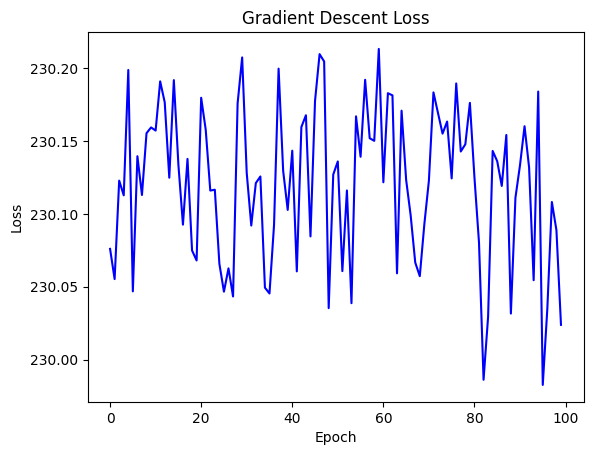

In [ ]:
# 그래프 출력

plt.plot(range(bat_size), losses_all_SoftMax, 'b-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Gradient Descent Loss')
plt.show()

3) Comparing Optimized code with Vanilla code using [epoch vs loss] graph

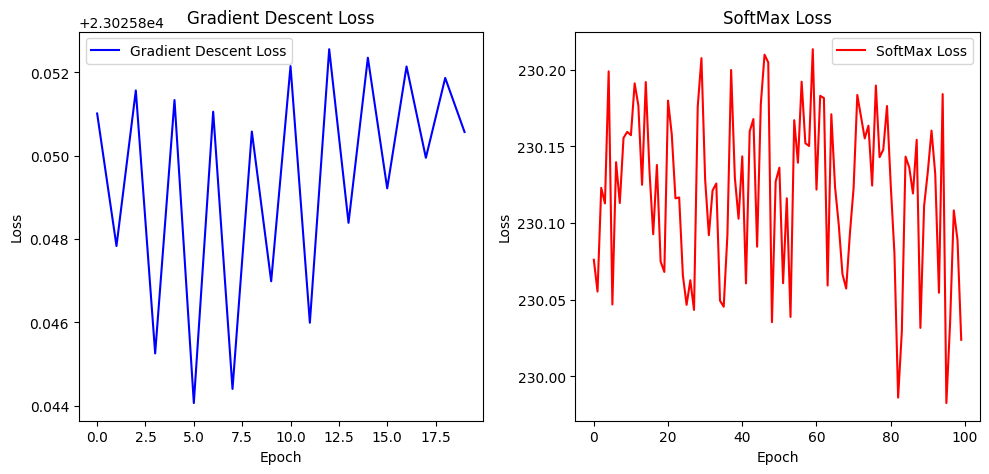

In [ ]:
# Figure와 두 개의 서브 플롯 생성
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# 첫 번째 서브 플롯: Vanilla code of Gradient Descent Loss
axs[0].plot(range(20), losses_GD, 'b-', label='Gradient Descent Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Gradient Descent Loss')

# 두 번째 서브 플롯: Optimized code of SoftMax Loss
axs[1].plot(range(bat_size), losses_all_SoftMax, 'r-', label='SoftMax Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].set_title('SoftMax Loss')

# 각 서브 플롯의 범례 표시
axs[0].legend()
axs[1].legend()

# 그래프 출력
plt.tight_layout()
plt.show()

두 그래프 비교 결과, SGD 방법으로 구현한 Optimized Code가 파형이 더 심하게 요동치는 것을 보이지만 loss가 더 잘 감소하는 방향으로 동작함을 확인하였다. 또한 앞서 측정한 accuracy로부터 최적화된 모델의 성능이 Vanilla Code보다 우수함을 알 수 있다.